In [346]:
!pip install pyodbc pandas matplotlib
!pip install scipy numpy
import scipy.stats as stats
import seaborn as sns
import pyodbc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import sem, norm

In [285]:
import pyodbc
import pandas as pd


connection = pyodbc.connect(
    'DRIVER={ODBC Driver 17 for SQL Server};'
    'SERVER=MSI\\SQLEXPRESS;' 
    'DATABASE=AdventureWorks2022;' 
    'Trusted_Connection=yes;' 
)



In [182]:
# Matthew Ahern-Hailu SQL Kunskapskontroll 2024

#  1. Beskriv kort hur en relationsdatabas fungerar.
# Like a spreadsheet, it saves data into coloumns and rows

# 2. Vad menas med “CRUD”-flödet?
# its a acrynomyn for actions we make on a database
# C is for Create data or adding data
# R is for Read, to get data
# U is Update, when we change data
# D is for Delete, when we delete data

# 3. Beskriv kort vad en “left join” och en “inner join” är. Varför använder man det?
# we use joins to combine data, so a left join would take all data from the left table and match it to the right. 
# Inner join combines data when the match from both tables only.

# 4. Beskriv kort vad indexering i SQL innebär.
# An index in SQL is like a sorted group of data, which helps us pull info forward quicker, 
# you could have an index which takes for example, all the tallest people from a dataset

# 5. Beskriv kort vad en vy i SQL är.
# A view is just an look at a specific part of the dataset, it doesnt save or edit the dataset, just pulls forward the info we want. 

# 6. Beskriv kort vad en lagrad procedur i SQL är.
# Is like a premade piece of code which does something whenever we ask it, it could be a code that changes prices, increases or decreases. 
# Instead of writing teh code everytime we use a dataset, a "lagrad procedur" does it for us, as we specify, makes things quicker.


In [186]:
# Scenario Task 1:
# The adventureworks2022 is vast database on a company that makes and sells Bike Gear and equipment. It includes data on various categories, 
# personel details, employment, sales, production and customers.


query = """
SELECT 
    TABLE_SCHEMA AS [Schema Name],
    TABLE_NAME AS [Table Name]
FROM 
    INFORMATION_SCHEMA.TABLES
WHERE 
    TABLE_TYPE = 'BASE TABLE'
ORDER BY 
    TABLE_SCHEMA, TABLE_NAME;
"""
    
df = pd.read_sql(query, connection)
print(df)
    
# The above code lets us look at the different Schemas in teh data set and the tables they contain

       Schema Name             Table Name
0              dbo         AWBuildVersion
1              dbo            DatabaseLog
2              dbo               ErrorLog
3   HumanResources             Department
4   HumanResources               Employee
..             ...                    ...
66           Sales  SalesTerritoryHistory
67           Sales       ShoppingCartItem
68           Sales           SpecialOffer
69           Sales    SpecialOfferProduct
70           Sales                  Store

[71 rows x 2 columns]


In [188]:
# Based on my previous career experience quality control and prodcution support, I want to look specifically at quality and the productions at our company.
# First, lets have a little look at the kind of products we have, and what info we can get on quality control.

query = """
SELECT * 
FROM Production.ScrapReason;
"""

df = pd.read_sql(query, connection)
print(df)

# As we can see, we have 16 different types of "Scrap Reasons" on our products, such as wheel misagnment, handling damage or incorrect colours.



    ScrapReasonID                             Name ModifiedDate
0               1    Brake assembly not as ordered   2008-04-30
1               2                  Color incorrect   2008-04-30
2               3                   Gouge in metal   2008-04-30
3               4          Drill pattern incorrect   2008-04-30
4               5             Drill size too large   2008-04-30
5               6             Drill size too small   2008-04-30
6               7                  Handling damage   2008-04-30
7               8             Paint process failed   2008-04-30
8               9            Primer process failed   2008-04-30
9              10     Seat assembly not as ordered   2008-04-30
10             11               Stress test failed   2008-04-30
11             12  Thermoform temperature too high   2008-04-30
12             13   Thermoform temperature too low   2008-04-30
13             14             Trim length too long   2008-04-30
14             15            Trim length

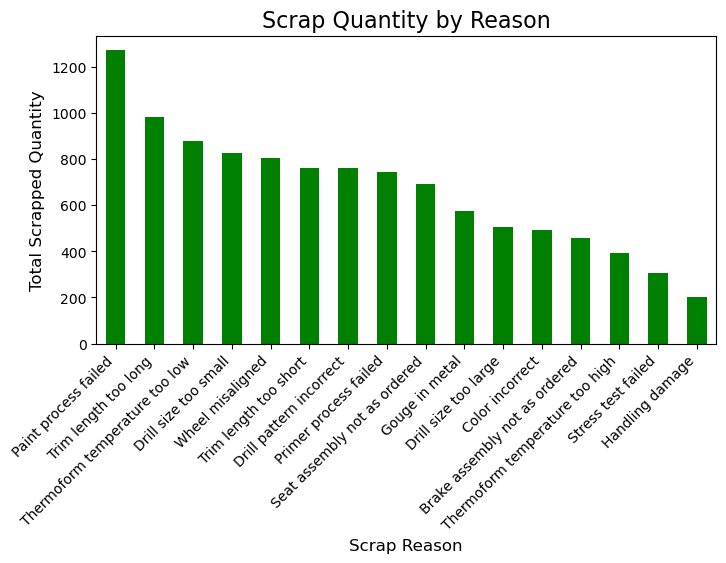

In [407]:
# Now we know the different types of problems our products can have, lets have a look at how often they've occured:

query = """
SELECT 
    p.Name AS Product,
    sr.Name AS Reason,
    SUM(wo.ScrappedQty) AS TotalScrapped
FROM Production.WorkOrder wo
LEFT JOIN Production.ScrapReason sr ON wo.ScrapReasonID = sr.ScrapReasonID
LEFT JOIN Production.Product p ON wo.ProductID = p.ProductID
WHERE wo.ScrappedQty > 0
GROUP BY p.Name, sr.Name
ORDER BY TotalScrapped DESC;
"""

df = pd.read_sql(query, connection)

reason_totals = df.groupby('Reason')['TotalScrapped'].sum().sort_values(ascending=False)

plt.figure(figsize=(8, 4))
reason_totals.plot(kind='bar', color='green')
plt.title('Scrap Quantity by Reason', fontsize=16)
plt.ylabel('Total Scrapped Quantity', fontsize=12)
plt.xlabel('Scrap Reason', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.show()

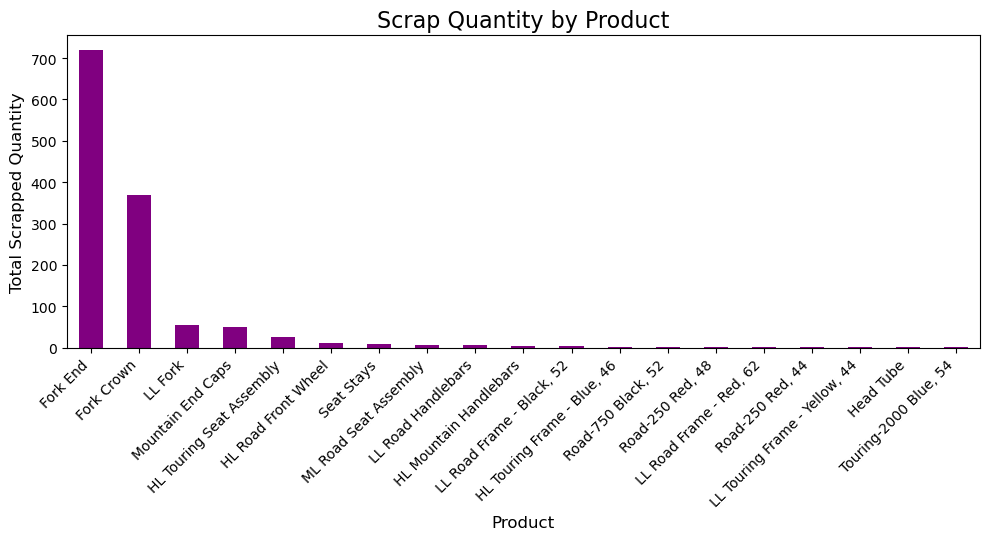

In [332]:
# As we can see from the bar chart, the most common Scrap reason was due to "paint process failed", 
# lets look a little closer at which products are being scrapped for this reason

query = """
SELECT 
    p.Name AS Product,
    sr.Name AS Reason,
    SUM(wo.ScrappedQty) AS TotalScrapped
FROM Production.WorkOrder wo
LEFT JOIN Production.ScrapReason sr ON wo.ScrapReasonID = sr.ScrapReasonID
LEFT JOIN Production.Product p ON wo.ProductID = p.ProductID
WHERE wo.ScrappedQty > 0 and sr.Name = 'Paint Process Failed'
GROUP BY p.Name, sr.Name
ORDER BY TotalScrapped DESC;
"""

df = pd.read_sql(query, connection)

product_totals = df.groupby('Product')['TotalScrapped'].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
product_totals.plot(kind='bar', color='purple')
plt.title('Scrap Quantity by Product', fontsize=16)
plt.ylabel('Total Scrapped Quantity', fontsize=12)
plt.xlabel('Product', fontsize=12)
plt.tight_layout()
plt.xticks(rotation=45, ha='right')
plt.show()

# We can see immediately that 2 products spefically, "fork ends/crowns" are scrapped way more than the other products, but how much does that cost us?

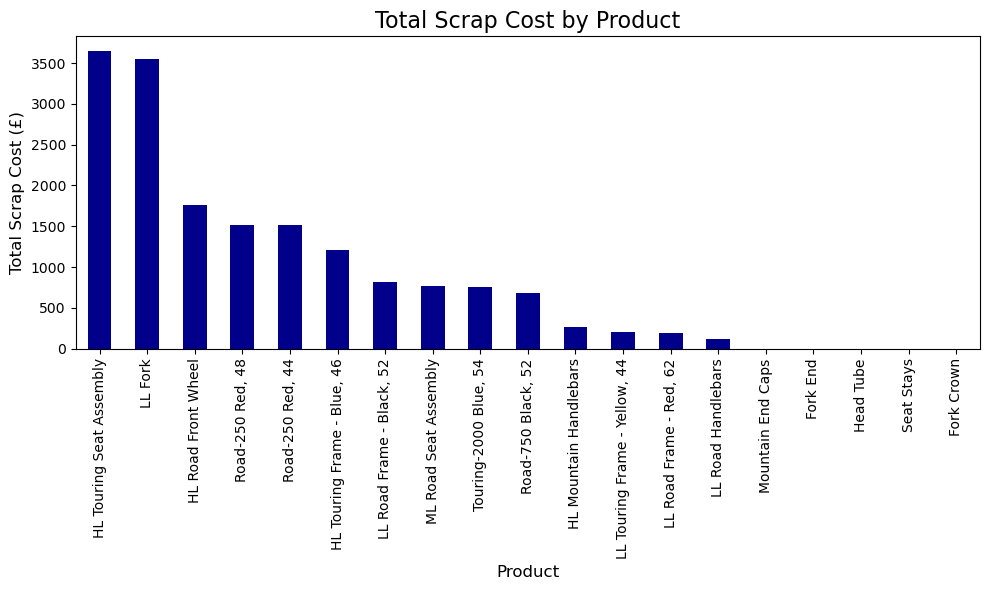

In [342]:
query = """
SELECT 
    p.Name AS Product,
    sr.Name AS Reason,
    SUM(wo.ScrappedQty) AS TotalScrapped,
    p.StandardCost AS CostPerUnit,
    SUM(wo.ScrappedQty * p.StandardCost) AS TotalScrapCost
FROM Production.WorkOrder wo
LEFT JOIN Production.ScrapReason sr ON wo.ScrapReasonID = sr.ScrapReasonID
LEFT JOIN Production.Product p ON wo.ProductID = p.ProductID
WHERE wo.ScrappedQty > 0 AND sr.Name = 'Paint Process Failed'
GROUP BY p.Name, sr.Name, p.StandardCost
ORDER BY TotalScrapCost DESC;
"""

df = pd.read_sql(query, connection)

product_cost_totals = df.groupby('Product')['TotalScrapCost'].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
product_cost_totals.plot(kind='bar', color='darkblue')
plt.title('Total Scrap Cost by Product', fontsize=16)
plt.ylabel('Total Scrap Cost (£)', fontsize=12)
plt.xlabel('Product', fontsize=12)
plt.tight_layout()
plt.show()

# As we can see from the plot of total scrap cost vs product, we have several products where the total cost is 0. I'm unsure why this is the case
# It could be that they have no manufacturing cost, or that we lack accurate data, it could be that they have no value because they havent been scrapped
# for said reason "Paint process failed, but as we can see for the "seat stays" or "fork end" products, some were scrapped, yet we dont see a cost for this action.
# Since i dont have a concrete answer, i elected to remove these values in my analysis. I believe they will make finding statisticson the data we do have, inaccurat.

In [354]:
filtered_df = df[df['TotalScrapCost'] > 0]

mean_scrap = filtered_df['TotalScrapCost'].mean()
std_err = sem(filtered_df['TotalScrapCost'])
ci_bounds = norm.interval(0.95, loc=mean_scrap, scale=std_err)

print(f"Mean Scrap Cost (Excluding 0 Values): £{mean_scrap:.2f}")
print(f"95% Confidence Interval: (£{ci_bounds[0]:.2f}, £{ci_bounds[1]:.2f})")
print(filtered_df.describe())

# Now i've removed the products which have 0 cost to scrap and analysed the data. As we can see we have an average total scrap cost of £894.
# It's not for me to determine whether thats high or low, but i am concerned with the variance of the data. What i mean is that our average might
# not fully represent our dataset, we can see from the previous bar chart that a couple of products cost a bit more in scrap, it looks like they might
# skew the data. Look at the result of our Confidence interval, that tells us that teh true average is between 616.75 and 1811.34. Thats quite a substantial
# gap. The mean £894.56 is quite a bit lower than the max total scrap cost for a product £3646.75, 
# so there seems to me theres a skew in the distributioon. This means a few expensiev outliers (like those near £3646.75) are pulling the mean upward.

Mean Scrap Cost (Excluding 0 Values): £1214.05
95% Confidence Interval: (£616.75, £1811.34)
       TotalScrapped  CostPerUnit  TotalScrapCost
count      14.000000    14.000000       14.000000
mean        8.714286   419.295929     1214.045493
std        14.573045   510.021627     1140.254995
min         1.000000    19.775800      118.654800
25%         1.000000   118.210000      372.074425
50%         3.000000   193.504500      790.715200
75%         6.750000   537.220175     1518.786400
max        54.000000  1518.786400     3646.750000


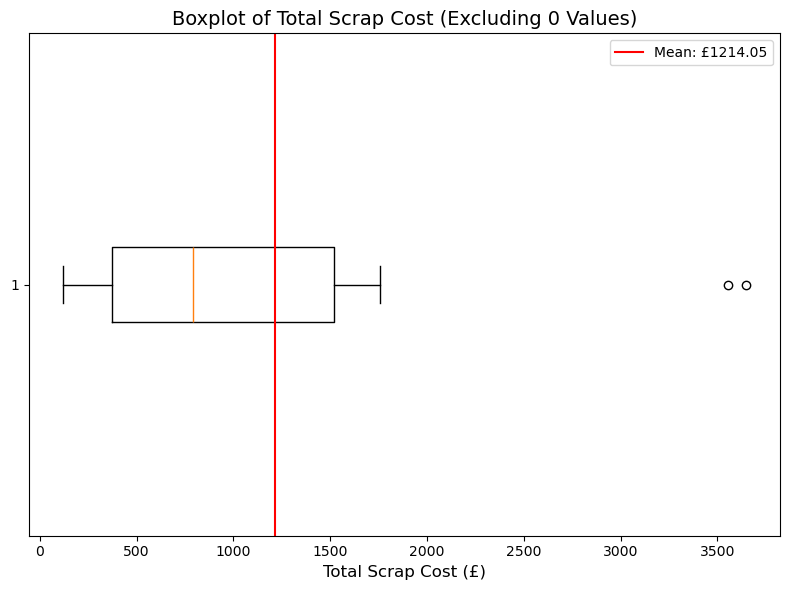

In [391]:
plt.figure(figsize=(8, 6))
plt.boxplot(
    filtered_df['TotalScrapCost'],  
    vert=False,
)
plt.axvline(mean_scrap, color='red', linestyle='-', label=f'Mean: £{mean_scrap:.2f}')
plt.title('Boxplot of Total Scrap Cost (Excluding 0 Values)', fontsize=14)
plt.xlabel('Total Scrap Cost (£)', fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

# My answer to part 3 is best visualised using a boxplot which show us the spread of data and any outliers.
# we have 2 outliers, beyong the interquartile range (the two white dots), what does this tell us? 
# As i see it, that since we are dealing with scrap costs that these outliers are not only expensive to the company, 
# but they also make our data slightly off. My suggestion is that we approach these two products: "HL Touring Seat Assembly" and "LL Fork", 
# and work on bringing down their production problems
# if we cam manage this not only would we save money (the highest cost alone is more than 3 times the average cost) 
# but we could also make our data on our average total scrap cost more accuirate.
# I think we should also note that there are probably hidden costs our dataset doesnt cover, we know we dont have costs for products like "fork ends"
# Even if we say they dont cost anything to the company to scrap, it still takes staff to do the work of scrapping and replacing etc, 
# which does cost time and money, so even these so called 0 scrap values should be investigated further!

In [380]:
# 1. Utmaningar du haft under arbetet samt hur du hanterat dem.
# Connecting SQL and Python was difficult, jumping back and forth between them etc, but the pyodbc package lets you write the SQL queries
# in Jupyter directly so that made things easier. 

# 2. Vilket betyg du anser att du skall ha och varför.
# I hope for G, i've tried my best to give analysis thats thoughtful and detailed.

# 3. Tips du hade gett till dig själv i början av kursen nu när du slutfört den.
# More practice and repetition, i forget the languages so easily and lose time refreshing myself. I could probably help myself by training more often.

#I recorded my presentation on 03.01.25